In [1]:
import os
import pandas as pd
import numpy as np
import time as tm
from scHPL import progressive_learning, predict, evaluate

During this vignette we will repeat the PBMC inter-dataset experiment. We use three datasets to construct a classification tree and use this tree to predict the labels of a fourth dataset. The aligned datasets and labels can be downloaded from https://doi.org/10.5281/zenodo.4557712

### Read the data

We start with reading the different datasets, corresponding labels and them to a list.

In the datasets, the rows represent different cells and columns represent the genes

In [2]:
data0 = 'Data_EQTL.csv'
labels0 = 'Labels_EQTL.csv'

data1 = 'Data_10Xv2.csv'
labels1 = 'Labels_10Xv2.csv'

data2 = 'Data_FACS.csv'
labels2 = 'Labels_FACS.csv'

data = []
labels = []

data.append((pd.read_csv(data0, index_col=0, sep=',')))
labels.append(pd.read_csv(labels0, header=0, index_col=None, sep=','))

data.append((pd.read_csv(data1, index_col=0, sep=',')))
labels.append(pd.read_csv(labels1, header=0, index_col=None, sep=','))

data.append((pd.read_csv(data2, index_col=0, sep=',')))
labels.append(pd.read_csv(labels2, header=0, index_col=None, sep=','))

### Construct and train the classification tree

Next, we use hierarchical progressive learning to construct and train a classification tree. After each iteration, an updated tree will be printed. If two labels have a perfect match, one of the labels will not be visible in the tree. Therefore, we will also indicate these perfect matches using a print statement

During this experiment, we used the linear SVM, didn't apply dimensionality reduction and used the default threshold of 0.25. In you want to use a one-class SVM instead of a linear, the following can be used: classifier = 'svm_occ'

In [3]:
start = tm.time()

classifier = 'svm'
dimred = False
threshold = 0.25
tree = progressive_learning.learn_tree(data, labels, 
                                       classifier = classifier, 
                                       dimred = dimred, 
                                       threshold = threshold)

training_time = tm.time()-start
print('Time to train scHPL on a normal desktop:', training_time)

Iteration  1 

Perfect match:  B cell - B-10Xv2 is now: B cell - eQTL
Perfect match:  Megakaryocyte - B-10Xv2 is now: Megakaryocyte - eQTL
Perfect match:  CD4+ T cell - B-10Xv2 is now: CD4+ T cell - eQTL
Perfect match:  CD8+ T cell - B-10Xv2 is now: CD8+ T cell - eQTL

Updated tree:
root
	B cell - eQTL
	CD4+ T cell - eQTL
	CD8+ T cell - eQTL
	Megakaryocyte - eQTL
	pDC - eQTL
	Monocyte - B-10Xv2
		CD14+ Monocyte - eQTL
		CD16+ Monocyte - eQTL
		mDC - eQTL
	NK cell - B-10Xv2
		CD56+ bright NK cell - eQTL
		CD56+ dim NK cell - eQTL
Iteration  2 

Perfect match:  B cell - FACS is now: B cell - eQTL
Perfect match:  CD14+ Monocyte - FACS is now: Monocyte - B-10Xv2
Perfect match:  CD34+ cell - FACS is now: pDC - eQTL

Updated tree:
root
	B cell - eQTL
	CD4+ T cell - eQTL
		CD4+/CD25 T Reg - FACS
		CD4+/CD45RA+/CD25- Naive T - FACS
		CD4+/CD45RO+ Memory - FACS
		CD8+/CD45RA+ Naive Cytotoxic - FACS
	Megakaryocyte - eQTL
	pDC - eQTL
	Monocyte - B-10Xv2
		CD14+ Monocyte - eQTL
		CD16+ Monocyte - 

### Predict the labels of the fourth dataset

In this last step, we use the learned tree to predict the labels of another dataset

In [4]:
data3 = 'Data_10Xv3.csv'
data_test = pd.read_csv(data3, index_col=0, sep=',')

start = tm.time()
pred_test = predict.predict_labels(data_test, tree)
pred_time = tm.time()-start
print('Time to make predictions with scHPL on a normal desktop:', pred_time)

Time to make predictions with scHPL on a normal desktop: 4.310481309890747


We compare these true and predicted labels by constructing a confusion matrix

In [5]:
labels3 = 'Labels_10Xv3.csv'
y_true = pd.read_csv(labels3, header=0, index_col=None, sep=',')
y_pred = pd.DataFrame(data = pred_test)

confmatrix = evaluate.confusion_matrix(y_true, y_pred)
confmatrix = confmatrix / np.sum(confmatrix.values, axis = 1, keepdims=True) #Normalize

This confusion matrix can be visualized using a heatmap.

In this heatmap, we notice that the predictions of the CD16+ Monocytes and mDC are switched, which is caused by the mislabeling of the cells in the eQTL dataset.

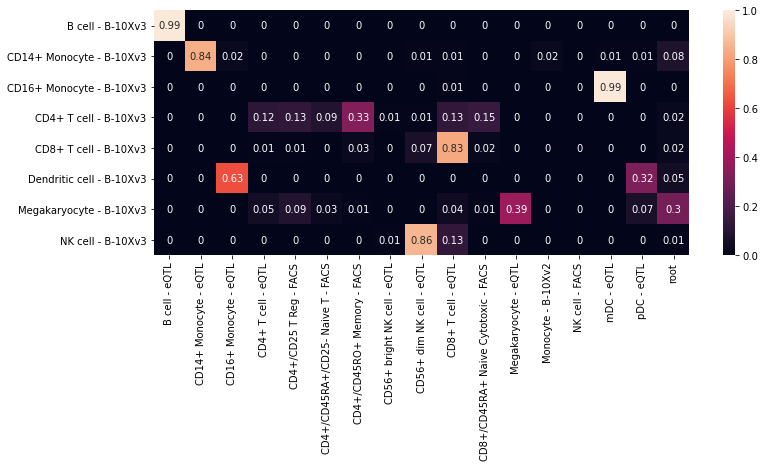

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
sns.heatmap(round(confmatrix,2), vmin = 0, vmax = 1, annot=True)
plt.show()